In [1]:
import numpy as np
import torch, torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((.5), (.5))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

In [4]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)

In [5]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

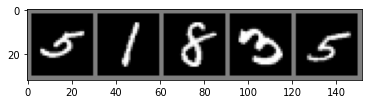

tensor(5) tensor(1) tensor(8) tensor(3) tensor(5)


In [6]:
itr = iter(trainloader)
images, labels = itr.next()
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % labels[j] for j in range(5)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 50, 3)
        self.conv2 = nn.Conv2d(50, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [8]:
stat_loss = []
net = Net()
net.to(device)
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
epoch_num = 2
for epoch in range(epoch_num):
    running_loss = 0.0
    i = 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        y_hat = net(x)
        loss = loss_func(y_hat, y)
        loss.backward()
        optim.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 2000}")
            stat_loss.append(running_loss / 2000)
            running_loss = 0.0
        i += 1
print("Finished training!")

Epoch: 1, Batch: 2000, Loss: 1.0046785778042395
Epoch: 1, Batch: 4000, Loss: 0.1888334801796591
Epoch: 1, Batch: 6000, Loss: 0.13495008487522137
Epoch: 1, Batch: 8000, Loss: 0.11147809730212975
Epoch: 1, Batch: 10000, Loss: 0.09400634105803693
Epoch: 1, Batch: 12000, Loss: 0.0918005255221251
Epoch: 2, Batch: 2000, Loss: 0.07338044353309488
Epoch: 2, Batch: 4000, Loss: 0.06830165826958819
Epoch: 2, Batch: 6000, Loss: 0.061851516717903225
Epoch: 2, Batch: 8000, Loss: 0.06827062493632911
Epoch: 2, Batch: 10000, Loss: 0.05579851850588511
Epoch: 2, Batch: 12000, Loss: 0.05092727066184364
Finished training!


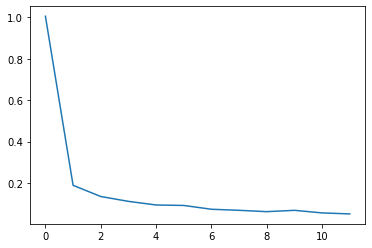

In [9]:
plt.plot(stat_loss)
plt.show()

In [10]:
correct, total = 0, 0
with torch.no_grad():
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        y_hat = net(x)
        _, predicted = torch.max(y_hat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 98.47%


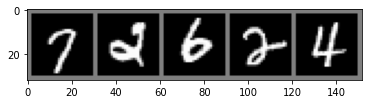

GroudTruth: tensor([7, 2, 6, 2, 4])
Prediction: tensor([7, 2, 6, 2, 4], device='cuda:0')
Confidence: tensor([0.9974, 0.9977, 0.9997, 0.9911, 0.9999], device='cuda:0')


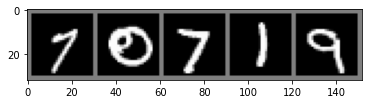

GroudTruth: tensor([7, 0, 7, 1, 9])
Prediction: tensor([7, 0, 7, 1, 9], device='cuda:0')
Confidence: tensor([0.9847, 0.9988, 1.0000, 0.9999, 0.9997], device='cuda:0')


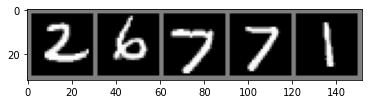

GroudTruth: tensor([2, 6, 7, 7, 1])
Prediction: tensor([2, 6, 7, 7, 1], device='cuda:0')
Confidence: tensor([0.9968, 0.9999, 0.9999, 0.9999, 0.9999], device='cuda:0')


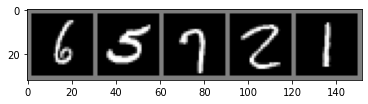

GroudTruth: tensor([6, 5, 7, 2, 1])
Prediction: tensor([6, 5, 7, 2, 1], device='cuda:0')
Confidence: tensor([0.9998, 0.9960, 0.9025, 0.9922, 0.9999], device='cuda:0')


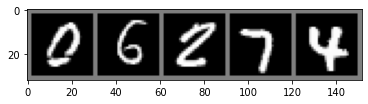

GroudTruth: tensor([0, 6, 2, 7, 4])
Prediction: tensor([0, 6, 2, 7, 4], device='cuda:0')
Confidence: tensor([0.9995, 0.9989, 0.8024, 0.9999, 0.9995], device='cuda:0')


In [14]:
itr = iter(trainloader)
for _ in range(5):
    images, labels = itr.next()
    imshow(torchvision.utils.make_grid(images))

    print('GroudTruth:', labels)
    print('Prediction:', torch.max(net(images.to(device)).data, 1)[1])
    print('Confidence:', torch.max(torch.exp(net(images.to(device))).data, 1)[0])

Original Image:


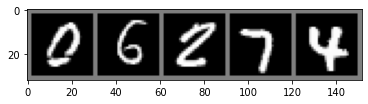

GroudTruth: tensor([0, 6, 2, 7, 4])
Prediction: tensor([0, 6, 2, 7, 4], device='cuda:0')
Confidence: tensor([0.9995, 0.9989, 0.8024, 0.9999, 0.9995], device='cuda:0')
Initial Seed:


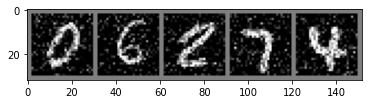

Prediction: tensor([0, 6, 8, 7, 4], device='cuda:0')
Confidence: tensor([0.9250, 0.9933, 0.6400, 0.9957, 0.9658], device='cuda:0')
After PGD:


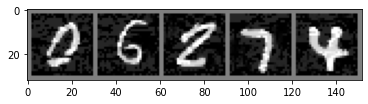

Prediction: tensor([2, 5, 8, 7, 7], device='cuda:0')
Confidence: tensor([0.6445, 0.9246, 0.9999, 0.9296, 0.9351], device='cuda:0')


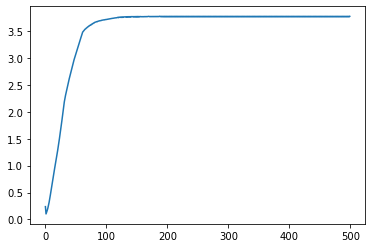

In [25]:
x = images.to(device)
adv_x = images.to(device).clone().detach().requires_grad_(True).to(device)
print("Original Image:")
imshow(torchvision.utils.make_grid(adv_x.detach().cpu()))
print('GroudTruth:', labels)
print('Prediction:', torch.max(net(images.to(device)).data, 1)[1])
print('Confidence:', torch.max(torch.exp(net(images.to(device))).data, 1)[0])

y = labels.to(device)
epsilon = 0.3
step_size = 0.01
steps_num = 500
# projected gradient descent
adv_x = adv_x + torch.randn(5, 1, 28, 28).to(device) * epsilon * 2 - epsilon
adv_x = torch.clamp(adv_x, -1, 1)
print("Initial Seed:")
imshow(torchvision.utils.make_grid(adv_x.detach().cpu()))
print('Prediction:', torch.max(net(adv_x).data, 1)[1])
print('Confidence:', torch.max(torch.exp(net(adv_x)).data, 1)[0])
stat_loss = []
for _ in range(steps_num):
    _adv_x = adv_x.clone().detach().requires_grad_(True)
    y_hat = net(_adv_x)
    loss = loss_func(y_hat, y)
    loss.backward()
    stat_loss.append(loss.item())
    #print(adv_x.grad)
    with torch.no_grad():
        gradient = step_size * torch.sign(_adv_x.grad)
        adv_x = torch.max(torch.min(adv_x + gradient, x + epsilon), x - epsilon)
        adv_x = torch.clamp(adv_x, -1, 1)
        
print("After PGD:")
imshow(torchvision.utils.make_grid(adv_x.detach().cpu()))
print('Prediction:', torch.max(net(adv_x).data, 1)[1])
print('Confidence:', torch.max(torch.exp(net(adv_x)).data, 1)[0])
plt.plot(stat_loss)
plt.show()